<a href="https://colab.research.google.com/github/biolographer/NanoparticlesSAM/blob/main/sam_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SEM particle annotation


In [ ]:
#!git clone https://github.com/Biolographer/NanoparticlesSAM.git

#!mv /content/MorphologyAnalysisFromSegmentation/SAM-BasedMethod/particle_loader.py /content/
#!mv /content/MorphologyAnalysisFromSegmentation/SAM-BasedMethod/particle_seg.py /content/
#!mv /content/MorphologyAnalysisFromSegmentation/SAM-BasedMethod/plots.py /content/

%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('NanoparticlesSAM/NanoparticlesSAM'))
sys.path.append(module_path)

In [ ]:
from NanoparticlesSAM import *
from particle_seg import *
from particle_loader import *
from plots import plot_seg_mask, plot_rect


In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import glob
import torchvision

#%matplotlib tk
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())


PyTorch version: 2.6.0
Torchvision version: 0.21.0
CUDA is available: False


In [ ]:
# installing segment anything model
!pip install 'git+https://github.com/facebookresearch/segment-anything.git'


  Cloning https://github.com/facebookresearch/segment-anything.git to /private/var/folders/hx/cphylf_x45bdc9bx9rm660lh0000gn/T/pip-req-build-xbbsg2mx
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /private/var/folders/hx/cphylf_x45bdc9bx9rm660lh0000gn/T/pip-req-build-xbbsg2mx
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done


In [ ]:
# download weights
# Nanoparticle paper used sam_vit_h_4b8939.pth checkpoint
HOME = os.getcwd()
print("HOME:", HOME)

!mkdir -p {HOME}/weights
if not os.path.exists(f'{HOME}/weights/sam_vit_h_4b8939.pth'):
    !curl -o {HOME}/weights/sam_vit_h_4b8939.pth "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"


HOME: /Users/aarondebon/bioinformatics/sem_pipeline


In [ ]:
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")
else:
    mps_device = torch.device("mps")
    print(f'available device: "{mps_device}"')

available device: "mps"


In [ ]:
DATA_DIR = 'testdata'
RESULT_DIR = 'results'

if os.path.isdir(RESULT_DIR):
  print('ok')
else:
  !mkdir {RESULT_DIR}

save_path = os.path.join(os.getcwd(),'results')
save_path

if os.path.isdir('testdata'):
  print('ok')
else:
  !mkdir {DATA_DIR}


ok
ok


In [ ]:
data_path = os.path.join(os.getcwd(), DATA_DIR)

img_set = Particle_Dataset(root = data_path, device='jeol')
print("Analyzing",img_set.__len__(),'imagens')

img_set.files

Setting "crop banner=True" due to jeol device
Analyzing 1 imagens


['A-2h-01.tif']

In [ ]:
sam_checkpoint = "weights/sam_vit_h_4b8939.pth"

if mps_device:
    device = mps_device
else:
    device = 'cpu'

## hardcoded this for laptop
device = 'cuda'

model_type = "vit_h"

from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

print(f'ok... device = {device}')

ok... device = cpu


In [ ]:
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=36,
    pred_iou_thresh=0.80,
    stability_score_thresh=0.80,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=350,  # Requires open-cv to run post-processing
)

0/1
Analyzing particle: A-2h-01


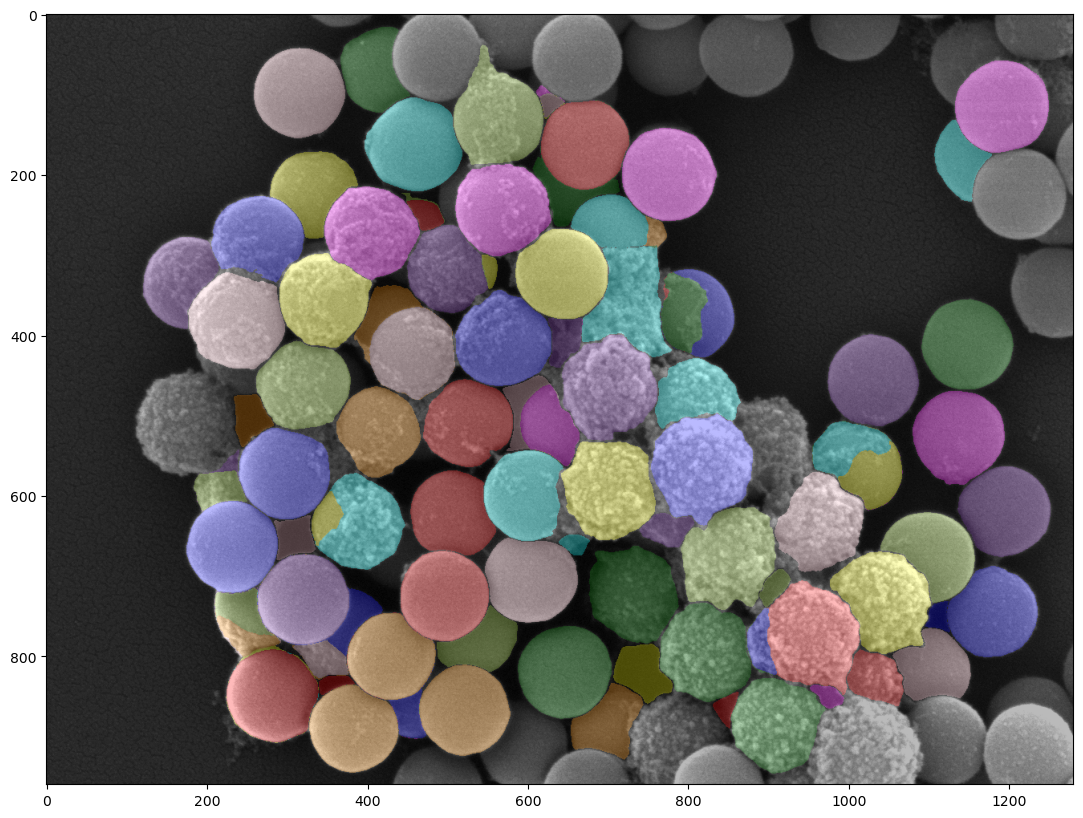

image from A-2h-01 saved!


In [ ]:
for idx in range(0,img_set.__len__()):

    print(f'{idx}/{img_set.__len__()}')

    #Get image
    img, name, metadata = img_set.__getitem__(idx)
    #img = cv2.imread(f'testdata/{img_set.files[idx]}')
    name = img_set.files[idx]

    saving_name = name.split('.')[0]
    print(f'Analyzing particle: {saving_name}')
    #Apply the SAM method
    combined_mask, simple_mask, dataframe_SAM = sphere_segmentation(img, mask_generator,
                                                                    nanometer_per_pixel=None,
                                                                    diameter_cutoff=50,
                                                                    circularity_cutoff = 0.75,
                                                                    border_cutoff=True)
    dataframe_SAM['img_name'] = saving_name
    # dataframe_SAM.to_excel(f'{save_path}/df_SAM_orig_{saving_name}.xlsx')

    #Combine masks
    #comb_mask = get_comb_mask_from_sam(dataframe_SAM)

    #Get properties from the predicted masks
    #sam_df = label_props_SAM(img, combined_mask)
    #sam_df['img_name'] = saving_name

    #Save results
    sam_df.to_csv(f'{save_path}/df_analyzed_{saving_name}.csv')

    #plot results
    plot_seg_mask(img, combined_mask)

    print(f'image from {saving_name} saved!')